# 0. Library

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
import pickle
import os

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# --- TabNet & PyTorch ---
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# 1. Utility functions + Configurations

## 1.1 Utility functions

In [2]:
# --- Helper Functions (can be imported from a utils file or redefined) ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    # Ensure y_true sums are not zero before division
    sum_true = df['y_true'].sum()
    sum_false = len(df) - sum_true
    if sum_true == 0 or sum_false == 0:
        return 0.0 # KS is 0 if one class is missing
    df['cumulative_true'] = df['y_true'].cumsum() / sum_true
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / sum_false
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
     # Handle cases where thresholds might not be strictly decreasing
    valid_indices = np.where(np.isfinite(thresholds))[0]
    if len(valid_indices) == 0:
        print("Warning: No valid thresholds found for J-statistic calculation.")
        return 0.5 # Default fallback
    fpr, tpr, thresholds = fpr[valid_indices], tpr[valid_indices], thresholds[valid_indices]

    if len(thresholds) == 0:
         print("Warning: Threshold array is empty after filtering.")
         return 0.5

    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    # Ensure threshold is within [0, 1] bounds if necessary due to floating point issues
    optimal_threshold = max(0.0, min(1.0, optimal_threshold))
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    # Add epsilon to probabilities for log_loss if necessary
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    results = {
        'Model': model_name,
        'AUC': auc_roc, 'Gini': gini, 'KS': ks, 'Accuracy': accuracy,
        'Precision': precision, 'Recall': recall, 'F1': f1,
        'Brier': brier, 'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    # Save the plot
    plot_filename = f"roc_curve_{model_name.replace(' ', '_')}.png"
    plt.savefig(plot_filename)
    print(f"ROC curve saved to {plot_filename}")
    plt.show()

## 1.2 Configurations

In [3]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './tabnet_outputs/' # Directory to save model/results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
SEED = 42
N_SPLITS = 10
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR'

# TabNet Specific Config
TABNET_PARAMS = dict(
    # Network architecture
    n_d=128,             
    n_a=128,              
    n_steps=10,          
    n_independent=6,    
    n_shared=6,     
    
    # Regularization
    gamma=1.7,         
    lambda_sparse=5e-4, 
    
    # Optimizer settings
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    
    # Learning rate scheduler
    scheduler_params=dict(
        mode="min", 
        patience=50,    
        min_lr=1e-4, 
        factor=0.5
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    
    mask_type='sparsemax',
    verbose=1,
    seed=42 
)

# Training Config
MAX_EPOCHS = 100
PATIENCE = 20
BATCH_SIZE = 4096
VIRTUAL_BATCH_SIZE = 1024

# --- Check for GPU ---
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Load Data and Preprocess

In [4]:
# --- Load Data ---
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train_final.csv')
    test_df = pd.read_csv(DATA_PATH + 'test_final.csv')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train_final.csv' and 'test_final.csv' are in {DATA_PATH}")
    exit()

# --- Prepare Data ---
y_train = train_df[TARGET].values # Use .values for numpy arrays
y_test = test_df[TARGET].values

# Drop Target and potentially ID
if ID_COL in train_df.columns:
    X_train = train_df.drop(columns=[TARGET, ID_COL])
    X_test = test_df.drop(columns=[TARGET, ID_COL])
else:
    X_train = train_df.drop(columns=[TARGET])
    X_test = test_df.drop(columns=[TARGET])

# Align columns just in case
common_cols = list(X_train.columns.intersection(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]
feature_names = X_train.columns.tolist()

Loading preprocessed data...
Data loaded successfully.


In [5]:
# --- Feature Selection: Low Variance Filter ---
print("\nApplying Low Variance Feature Selection...")
var_selector = VarianceThreshold(threshold=0.01)

# Fit on training data only
var_selector.fit(X_train)

# Get the boolean mask of selected features
feature_mask = var_selector.get_support()
original_feature_names = X_train.columns.tolist() # Get original names before transformation
selected_feature_names = [name for name, selected in zip(original_feature_names, feature_mask) if selected]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after variance thresholding: {len(selected_feature_names)}")

# Transform both X_train and X_test
X_train_np_selected = var_selector.transform(X_train)
X_test_np_selected = var_selector.transform(X_test)

# Convert back to DataFrame with selected column names
X_train = pd.DataFrame(X_train_np_selected, columns=selected_feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_np_selected, columns=selected_feature_names, index=X_test.index)

# Update the global feature_names list
feature_names = selected_feature_names

print(f"Updated X_train shape: {X_train.shape}")
print(f"Updated X_test shape: {X_test.shape}")


Applying Low Variance Feature Selection...
Original number of features: 773
Number of features after variance thresholding: 542
Updated X_train shape: (246005, 542)
Updated X_test shape: (61502, 542)


In [6]:
# --- LIMITATION: Treat all features as numerical ---
# Ideally, identify original categorical features and pass their indices to TabNet.
# Since we are using pre-encoded data, we treat all as numerical.
print("WARNING: Treating all features as numerical for TabNet due to pre-encoded input data.")
categorical_indices = [] # No categorical indices provided
categorical_dims = [] # No specific dimensions needed if indices are empty

# Handle infinite values and NaNs
# Replace inf with NaN, then fill NaN with median of each column
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()) # Use train median for test set

# Standardize the data
# Note: TabNet can handle raw data, but standardization may help in some cases.
# You can comment this out if you prefer to use raw data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to numpy arrays of type float32 for PyTorch
X_train_np = X_train.astype(np.float32)
X_test_np = X_test.astype(np.float32)

print(f"Prepared X_train shape: {X_train_np.shape}")
print(f"Prepared X_test shape: {X_test_np.shape}")

Prepared X_train shape: (246005, 542)
Prepared X_test shape: (61502, 542)


# 3. Train and Evaluate

## 3.1 Train Baseline Model

In [7]:
# Calculate class weights inversely proportional to class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
# More aggressive weighting for minority class
class_weights = torch.tensor([1.0, (class_counts[0]/class_counts[1]) * 1.0], dtype=torch.float32)
if device_name == 'cuda':
    class_weights = class_weights.cuda()

print(f"Using class weights: {class_weights.cpu().numpy()} to emphasize minority class")

# Create weighted loss function
weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

Using class weights: [ 1.       11.386959] to emphasize minority class



Training Baseline TabNet High Model without CV...
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3060
Current CUDA device: 0
Using device: cuda for TabNet model


c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNet High model initialized on cuda
Fitting baseline TabNet High model...
epoch 0  | loss: 1.96024 | validation_auc: 0.49868 | validation_balanced_accuracy: 0.49475 |  0:00:15s
epoch 1  | loss: 1.97337 | validation_auc: 0.48753 | validation_balanced_accuracy: 0.50447 |  0:00:30s
epoch 2  | loss: 1.99352 | validation_auc: 0.5023  | validation_balanced_accuracy: 0.50878 |  0:00:49s
epoch 3  | loss: 4.71576 | validation_auc: 0.52579 | validation_balanced_accuracy: 0.52257 |  0:01:09s
epoch 4  | loss: 1.09281 | validation_auc: 0.54443 | validation_balanced_accuracy: 0.52093 |  0:01:26s
epoch 5  | loss: 0.71925 | validation_auc: 0.64722 | validation_balanced_accuracy: 0.59942 |  0:01:41s
epoch 6  | loss: 0.6626  | validation_auc: 0.65747 | validation_balanced_accuracy: 0.61022 |  0:01:57s
epoch 7  | loss: 0.65705 | validation_auc: 0.66968 | validation_balanced_accuracy: 0.62019 |  0:02:12s
epoch 8  | loss: 0.64758 | validation_auc: 0.67301 | validation_balanced_accuracy: 0.62495 |  0:02:2

c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Baseline model training completed in 1094.45 seconds.

--- Baseline TabNet Model Evaluation ---

--- Evaluation Metrics for TabNet_High (Baseline) ---
AUC ROC:        0.7557
Gini Coefficient: 0.5114
KS Statistic:   0.3834
Accuracy:       0.6643
Precision:      0.1568
Recall (TPR):   0.7219
F1-Score:       0.2577
Brier Score:    0.2104
Log Loss:       0.6101

Confusion Matrix:
[[37271 19266]
 [ 1381  3584]]
ROC curve saved to roc_curve_TabNet_(Baseline).png


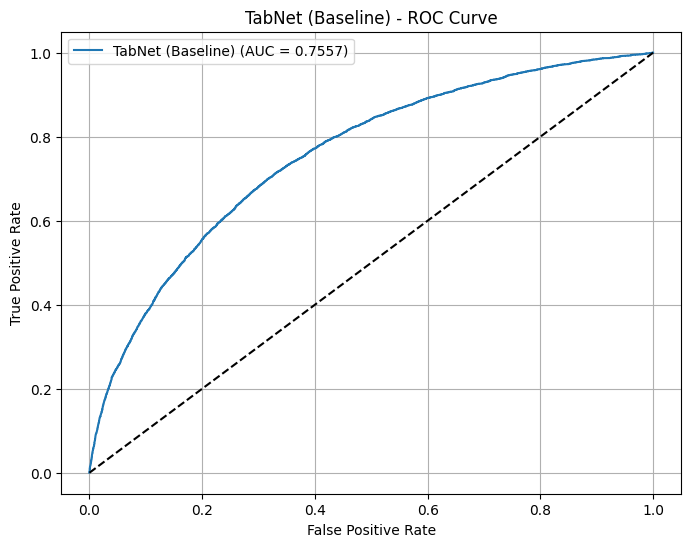

Successfully saved model at ./tabnet_outputs/tabnet_high_baseline_model.zip
Baseline model saved to ./tabnet_outputs/tabnet_high_baseline_model.zip
Baseline results saved to ./tabnet_outputs/tabnet_high_baseline_results.csv
Baseline feature importance saved to ./tabnet_outputs/tabnet_high_baseline_feature_importance.csv


In [8]:
# --- Initialize and Train a Baseline TabNet Model ---
print("\nTraining Baseline TabNet High Model without CV...")

# First, explicitly check and print GPU information
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    # Force CUDA device if available
    device_name = 'cuda'
else:
    print("Warning: CUDA not available, using CPU")
    device_name = 'cpu'

# Make sure TABNET_PARAMS has device_name set correctly
TABNET_PARAMS['device_name'] = device_name
print(f"Using device: {device_name} for TabNet model")

# Split off a small portion of the training data for validation (early stopping purposes)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_np, y_train, test_size=0.20, random_state=SEED, stratify=y_train
)

# Initialize the TabNet model with the parameters defined in TABNET_PARAMS
tabnet_baseline = TabNetClassifier(**TABNET_PARAMS)
print(f"TabNet High model initialized on {device_name}")

# Train the model with early stopping based on validation set
print("Fitting baseline TabNet High model...")
start_time = time.time()

tabnet_baseline.fit(
    X_train=X_train_base, y_train=y_train_base,
    eval_set=[(X_val_base, y_val_base)],
    eval_name=['validation'],
    eval_metric=['auc', 'balanced_accuracy'],
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    batch_size=BATCH_SIZE,
    virtual_batch_size=VIRTUAL_BATCH_SIZE,
    drop_last=False,
    loss_fn=weighted_loss,
    num_workers=0,
)

end_time = time.time()
print(f"Baseline model training completed in {(end_time - start_time):.2f} seconds.")

# Make predictions
baseline_preds = tabnet_baseline.predict_proba(X_test_np)[:, 1]
baseline_binary_preds = (baseline_preds > 0.5).astype(int)

# Evaluate the baseline model
print("\n--- Baseline TabNet Model Evaluation ---")
baseline_results = evaluate_model(
    y_test, baseline_preds, baseline_binary_preds, model_name="TabNet_High (Baseline)"
)

# Plot ROC curve
plot_roc_curve(y_test, baseline_preds, "TabNet (Baseline)")

# Save the model
baseline_model_path = os.path.join(MODEL_OUTPUT_PATH, "tabnet_high_baseline_model")
saved_baseline_path = tabnet_baseline.save_model(baseline_model_path)
print(f"Baseline model saved to {saved_baseline_path}")

# Save baseline results
baseline_results_df = pd.DataFrame([baseline_results])
baseline_results_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_high_baseline_results.csv")
baseline_results_df.to_csv(baseline_results_filename, index=False, mode='w+')
print(f"Baseline results saved to {baseline_results_filename}")

# Feature importance from baseline model
baseline_importance = tabnet_baseline.feature_importances_
baseline_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': baseline_importance})
baseline_importance_df = baseline_importance_df.sort_values(by='Importance', ascending=False)
baseline_importance_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_high_baseline_feature_importance.csv")
baseline_importance_df.to_csv(baseline_importance_filename, index=False, mode='w+')
print(f"Baseline feature importance saved to {baseline_importance_filename}")

In [9]:
# Get the optimal threshold using the validation set
optimal_threshold = find_optimal_threshold_j_statistic(y_val_base, tabnet_baseline.predict_proba(X_val_base)[:, 1])
print(f"Optimal threshold for validation set: {optimal_threshold:.4f}")

# Apply the optimal threshold to the test set predictions
baseline_binary_preds_optimal = (baseline_preds > optimal_threshold).astype(int)
# Evaluate the model with the optimal threshold
print("\n--- Baseline TabNet Model Evaluation with Optimal Threshold ---")
baseline_results_optimal = evaluate_model(
    y_test, baseline_preds, baseline_binary_preds_optimal, model_name="TabNet_High (Baseline with Optimal Threshold)"
)

# Save the results with the optimal threshold
baseline_results_optimal_df = pd.DataFrame([baseline_results_optimal])
baseline_results_optimal_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_high_baseline_results_optimal.csv")
baseline_results_optimal_df.to_csv(baseline_results_optimal_filename, index=False, mode='w+')
print(f"Baseline results with optimal threshold saved to {baseline_results_optimal_filename}")

Optimal threshold based on Youden's J-Statistic (OOF): 0.4937
Optimal threshold for validation set: 0.4937

--- Baseline TabNet Model Evaluation with Optimal Threshold ---

--- Evaluation Metrics for TabNet_High (Baseline with Optimal Threshold) ---
AUC ROC:        0.7557
Gini Coefficient: 0.5114
KS Statistic:   0.3834
Accuracy:       0.6565
Precision:      0.1550
Recall (TPR):   0.7309
F1-Score:       0.2557
Brier Score:    0.2104
Log Loss:       0.6101

Confusion Matrix:
[[36746 19791]
 [ 1336  3629]]
Baseline results with optimal threshold saved to ./tabnet_outputs/tabnet_high_baseline_results_optimal.csv
